In [1]:
from matplotlib import pyplot as plt
import numpy as np
from typing import Dict, List, Union


class SSRSimAPI:

    def load_model(self, *args, **kwargs):
        raise NotImplementedError

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        raise NotImplementedError

In [2]:
from roadrunner import RoadRunner


class RoadRunnerSSR(SSRSimAPI):

    def __init__(self):
        self.rr = None

    def load_model(self, *args, **kwargs):
        self.rr = RoadRunner(*args)

    def produce_results(self, names: List[str], times: List[float], sample_info: Union[int, List[Dict[str, float]]]) -> Dict[str, np.ndarray]:
        if isinstance(sample_info, int):
            sample_size = sample_info
            do_sampling = False
        else:
            sample_size = len(sample_info)
            do_sampling = True

        results = {n: np.ndarray((sample_size, len(times)), dtype=float) for n in names}
        for i in range(sample_size):
            self.rr.resetAll()
            if do_sampling:
                for n, v in sample_info[i].items():
                    self.rr[n] = v
            res = self.rr.simulate(times=times)
            for n in names:
                results[n][i, :] = res[f'[{n}]']
        return results

In [3]:
model_names = ['S', 'I', 'R', 'V']
time_final = 10.0
num_steps = 100

results_times = np.linspace(0., time_final, num_steps)
sample_size = 10000

with open('model_normal.xml', 'r') as f:
    model_normal_fun = f.read()
with open('model_uniform.xml', 'r') as f:
    model_uniform_fun = f.read()

rr_normal = RoadRunnerSSR()
rr_normal.load_model(model_normal_fun)
rr_uniform = RoadRunnerSSR()
rr_uniform.load_model(model_uniform_fun)

res_normal = rr_normal.produce_results(model_names, results_times, sample_size)
res_uniform = rr_uniform.produce_results(model_names, results_times, sample_size)
res_normal2 = rr_normal.produce_results(model_names, results_times, sample_size)

results_all = [res_normal, res_uniform, res_normal2]

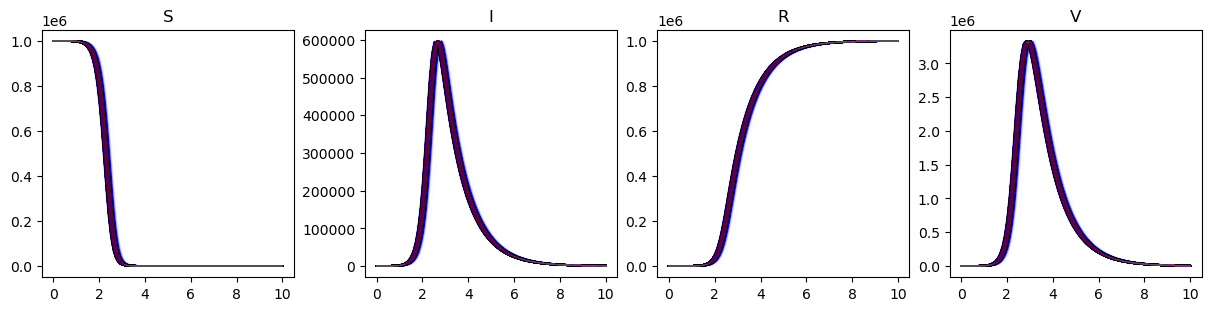

In [4]:
fig, axs = plt.subplots(1, len(model_names), layout='compressed', figsize=(12, 3))
for i, n in enumerate(model_names):
    for j in range(sample_size):
        axs[i].plot(results_times, res_normal[n][j, :], alpha=0.01, color='blue')
        axs[i].plot(results_times, res_uniform[n][j, :], alpha=0.01, color='orange')
    axs[i].set_title(n)

In [5]:
import libssr

num_evals = 100
num_pers = 5

eval_t_all = {n: [0.0] * num_steps for n in model_names}

for name in model_names:
    for i in range(num_steps):
        eval_t_all[name][i] = libssr.get_eval_info_times(num_evals, libssr.eval_final(res_normal[name][:, i].T[:], num_pers))

ecf_all = []
for _res in results_all:
    ecf_j = {}
    for name in model_names:
        ecf_n = np.ndarray((num_steps, num_evals, 2), dtype=float)
        for i in range(num_steps):
            ecf_n[i, :, :] = libssr.ecf(_res[name][:, i].T, eval_t_all[name][i]).copy()
        ecf_j[name] = ecf_n.copy()
    ecf_all.append(ecf_j)

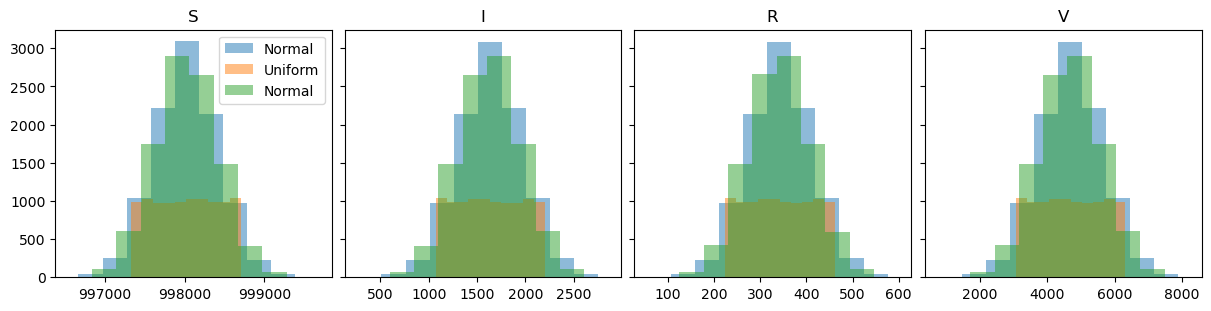

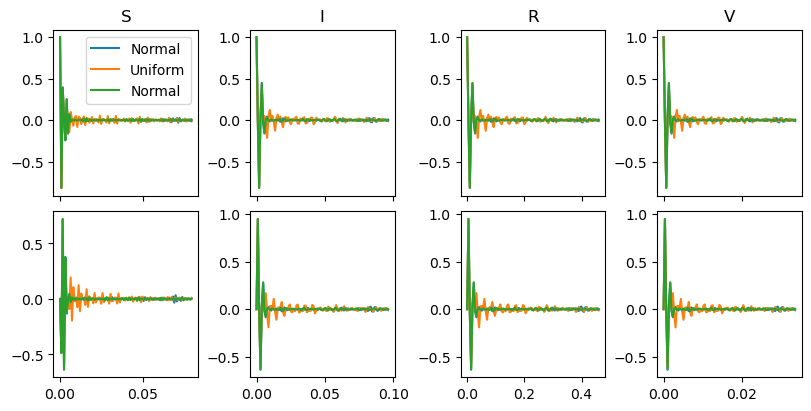

In [6]:
step_oi = 10

dist_labels = ['Normal', 'Uniform', 'Normal']

fig, ax = plt.subplots(1, len(model_names), figsize=(12.0, 3.0), layout='compressed', sharey=True)
for i, name in enumerate(model_names):
    for res in results_all:
        ax[i].hist(res[name][:, step_oi], alpha=0.5)
    ax[i].set_title(name)
ax[0].legend(dist_labels)

fig, ax = plt.subplots(2, len(model_names), figsize=(8.0, 4.0), layout='compressed', sharex='col')
for i, name in enumerate(model_names):
    eval_t = libssr.get_eval_info_times(num_evals, libssr.eval_final(results_all[0][name].T[step_oi, :], num_pers))
    
    for j, ecf_j in enumerate(ecf_all):
        ax[0][i].plot(eval_t, ecf_j[name][step_oi, :, 0], label=dist_labels[j])
        ax[1][i].plot(eval_t, ecf_j[name][step_oi, :, 1], label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].legend(dist_labels)

In [7]:
ecf_diff = []
err_max_idx = 0
err_max_val = 0
for j, ecf_j in enumerate(ecf_all[1:]):
    ecf_diff_j = {}
    for name in model_names:
        ecf_diff_name = 0.0
        for i in range(num_steps):
            err_ij = libssr.ecf_compare(ecf_all[0][name][i, :], ecf_j[name][i, :])
            ecf_diff_name = max(ecf_diff_name, err_ij)
            if j == 1 and err_ij > err_max_val:
                err_max_val = err_ij
                err_max_idx = i
        ecf_diff_j[name] = ecf_diff_name
    ecf_diff.append(ecf_diff_j.copy())

print(f'Maximum error compared to Normal sample occurred at simulation time {results_times[err_max_idx]}')
for j in range(len(ecf_diff)):
    print(f'{dist_labels[j+1]} error: {max(ecf_diff[j].values())} ({ecf_diff[j]})')

Maximum error compared to Normal sample occurred at simulation time 1.5151515151515151
Uniform error: 0.26124493434616164 ({'S': 0.26124472482859085, 'I': 0.2612448354564615, 'R': 0.2612447874930025, 'V': 0.26124493434616164})
Normal error: 0.04518609976610478 ({'S': 0.04518463537340646, 'I': 0.04518609976610478, 'R': 0.04517022004294154, 'V': 0.04518266720226257})


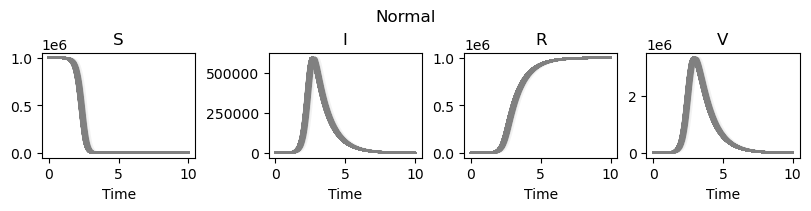

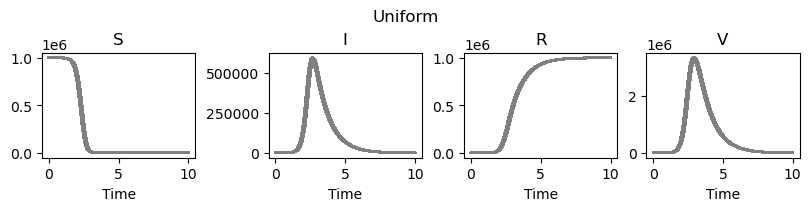

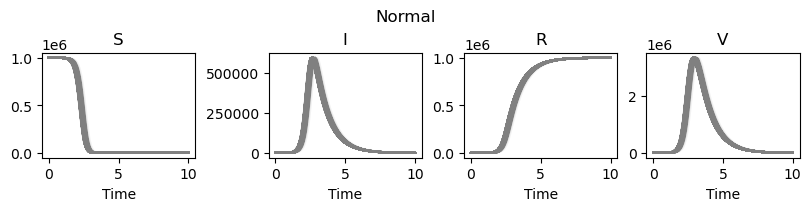

In [8]:
for k in range(len(results_all)):
    fig, ax = plt.subplots(1, len(model_names), figsize=(8.0, 2.0), layout='compressed')
    for i, n in enumerate(model_names):
        for j in range(sample_size):
            ax[i].plot(results_times, results_all[k][n][j, :], alpha=0.1, color='gray')
        ax[i].set_title(n)
        ax[i].set_xlabel('Time')
    fig.suptitle(dist_labels[k])

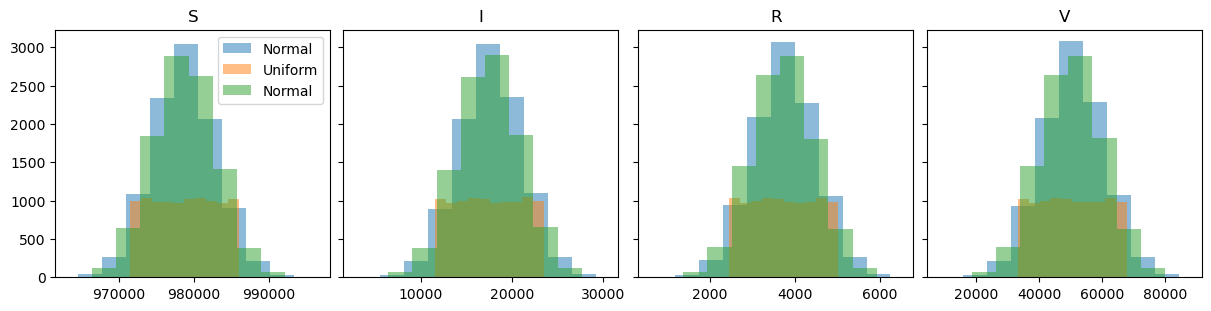

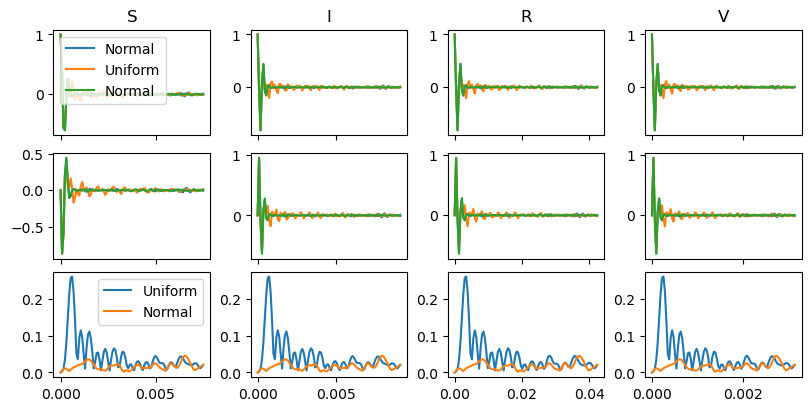

In [9]:
fig, ax = plt.subplots(1, len(model_names), figsize=(12.0, 3.0), layout='compressed', sharey=True)
for i, name in enumerate(model_names):
    for res in results_all:
        ax[i].hist(res[name][:, err_max_idx], alpha=0.5)
    ax[i].set_title(name)
ax[0].legend(dist_labels)

fig, ax = plt.subplots(3, len(model_names), figsize=(8.0, 4.0), layout='compressed', sharex='col')
for i, name in enumerate(model_names):
    eval_t = libssr.get_eval_info_times(num_evals, libssr.eval_final(results_all[0][name][:, err_max_idx].T, num_pers))
    
    for j, ecf_j in enumerate(ecf_all):
        ax[0][i].plot(eval_t, ecf_j[name][err_max_idx, :, 0], label=dist_labels[j])
        ax[1][i].plot(eval_t, ecf_j[name][err_max_idx, :, 1], label=dist_labels[j])
        
        if j > 0:
            err = np.sqrt(np.square(ecf_j[name][err_max_idx, :, 0] - ecf_all[0][name][err_max_idx, :, 0]) + np.square(ecf_j[name][err_max_idx, :, 1] - ecf_all[0][name][err_max_idx, :, 1]))
            ax[2][i].plot(eval_t, err, label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].legend(dist_labels)
ax[2][0].legend(dist_labels[1:])

In [14]:
import antimony
from numpy import random

def antimony_to_sbml(model_string: str) -> str:
    antimony.clearPreviousLoads()
    antimony.loadAntimonyString(model_string)
    module_name = antimony.getMainModuleName()
    return antimony.getSBMLString(module_name)

v_mean = 100.0
v_stdev = 20.0
model_names = ['S', 'I', 'R', 'V']
time_final = 10.0
num_steps = 100

model_str_antm = f"""
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
// V = normal({v_mean}, {v_stdev}, 0, {v_mean * 1E6});
V = 100.0;

beta = 2.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""

model_str_sbml = antimony_to_sbml(model_str_antm)
rr_normal_expl = RoadRunnerSSR()
rr_normal_expl.load_model(model_str_sbml)
rng = random.default_rng()
res_normal3 = rr_normal_expl.produce_results(model_names, results_times, [{'V': v} for v in random.normal(v_mean, v_stdev, size=sample_size)])

results_all2 = [res_normal, res_normal2, res_normal3]

In [17]:
ecf_all2 = []
for _res in results_all2:
    ecf_j = {}
    for name in model_names:
        ecf_n = np.ndarray((num_steps, num_evals, 2), dtype=float)
        for i in range(num_steps):
            ecf_n[i, :, :] = libssr.ecf(_res[name][:, i].T, eval_t_all[name][i]).copy()
        ecf_j[name] = ecf_n.copy()
    ecf_all2.append(ecf_j)

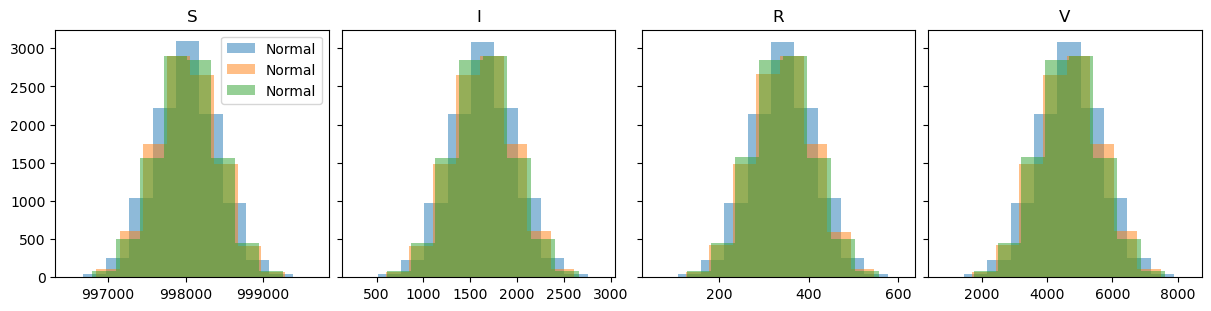

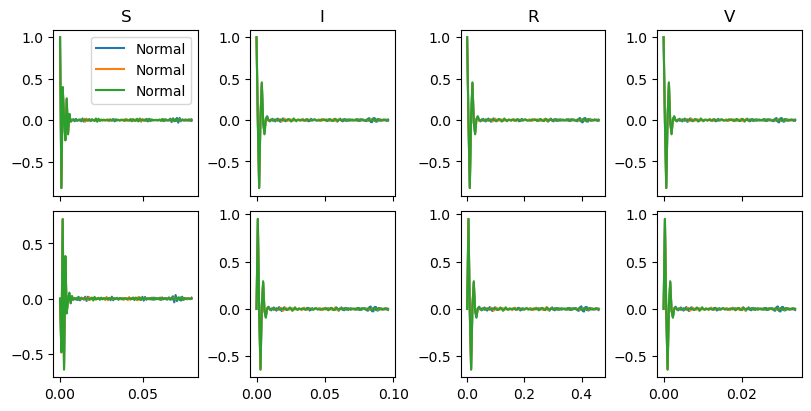

In [18]:
step_oi = 10

dist_labels = ['Normal', 'Normal', 'Normal']

fig, ax = plt.subplots(1, len(model_names), figsize=(12.0, 3.0), layout='compressed', sharey=True)
for i, name in enumerate(model_names):
    for res in results_all2:
        ax[i].hist(res[name][:, step_oi], alpha=0.5)
    ax[i].set_title(name)
ax[0].legend(dist_labels)

fig, ax = plt.subplots(2, len(model_names), figsize=(8.0, 4.0), layout='compressed', sharex='col')
for i, name in enumerate(model_names):
    eval_t = libssr.get_eval_info_times(num_evals, libssr.eval_final(results_all2[0][name].T[step_oi, :], num_pers))
    
    for j, ecf_j in enumerate(ecf_all2):
        ax[0][i].plot(eval_t, ecf_j[name][step_oi, :, 0], label=dist_labels[j])
        ax[1][i].plot(eval_t, ecf_j[name][step_oi, :, 1], label=dist_labels[j])
    
    ax[0][i].set_title(name)
ax[0][0].legend(dist_labels)

In [19]:
ecf_diff = []
err_max_idx = 0
err_max_val = 0
for j, ecf_j in enumerate(ecf_all2[1:]):
    ecf_diff_j = {}
    for name in model_names:
        ecf_diff_name = 0.0
        for i in range(num_steps):
            err_ij = libssr.ecf_compare(ecf_all2[0][name][i, :], ecf_j[name][i, :])
            ecf_diff_name = max(ecf_diff_name, err_ij)
            if j == 2 and err_ij > err_max_val:
                err_max_val = err_ij
                err_max_idx = i
        ecf_diff_j[name] = ecf_diff_name
    ecf_diff.append(ecf_diff_j.copy())

print(f'Maximum error compared to Normal sample occurred at simulation time {results_times[err_max_idx]}')
for j in range(len(ecf_diff)):
    print(f'{dist_labels[j+1]} error: {max(ecf_diff[j].values())} ({ecf_diff[j]})')

Maximum error compared to Normal sample occurred at simulation time 0.0
Normal error: 0.04518609976610478 ({'S': 0.04518463537340646, 'I': 0.04518609976610478, 'R': 0.04517022004294154, 'V': 0.04518266720226257})
Normal error: 0.045337042989778704 ({'S': 0.039517600211361574, 'I': 0.04328764051207928, 'R': 0.04421341356975218, 'V': 0.045337042989778704})
